In [26]:

%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('../')

# Graph imports
import src.graph as graph
import src.logit_estimator as estimator
import src.utils as utils
import src.model_selection as model_selection
import src.gic as gic
import src.param_estimator as pe
import src.graph as graph
import src.model_selection as ms

# usual imports import matplotlib.pyplot as plt
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx

from IPython.display import display

from pyvis.network import Network

import pickle
import os

import math
from mpl_toolkits.axes_grid1 import make_axes_locatable


np.random.seed(42)
datasets = f'../data/connectomes/'
#already_done = os.listdir('../images/imgs_connectomes/') 
#excluded = ['c.elegans.herm_pharynx_1.graphml']
#already_done = [os.path.splitext(file)[0] for file in already_done] + excluded

connectomes = sorted(os.listdir(datasets)) 
#connectomes = [connectome for connectome in connectomes if connectome not in already_done]
print(connectomes)

# Ensure the necessary directories exist
os.makedirs('../images/imgs_connectomes/', exist_ok=True)
os.makedirs('../images/imgs_spectra/', exist_ok=True)
os.makedirs('../images/search_neighbors/', exist_ok=True)



def get_logit_graph(real_graph, d, n_iteration, warm_up, patience, dist_type='KL'):
   # Ensure real_graph is a NumPy array
   if isinstance(real_graph, nx.Graph):
       real_graph = nx.to_numpy_array(real_graph)
   
   # Estimation
   est = estimator.LogitRegEstimator(real_graph, d=d)
   features, labels = est.get_features_labels()
   result, params, pvalue = est.estimate_parameters(l1_wt=1, alpha=0, features=features, labels=labels)
   sigma = params[0]

   # Generation
   n = real_graph.shape[0]

   params_dict = {
      "n": n,
      "d": d,
      "sigma": sigma,
      "n_iteration": n_iteration,
      "warm_up": warm_up
   }

   graph_model = graph.GraphModel(n=n, d=d, sigma=sigma)
   graphs, spec, spectrum_diffs, best_iteration = graph_model.populate_edges_spectrum(
       warm_up=warm_up,
       max_iterations=n_iteration,
       patience=patience,  # You may want to adjust this value
       real_graph=real_graph
   )

   # Add early stopping condition
   if len(spectrum_diffs) > 10000 and all(abs(spectrum_diffs[-1] - sd) < 1e-6 for sd in spectrum_diffs[-10000:]):
       print("Early stopping: No significant improvement in the last 1000 iterations.")
       best_iteration = len(spectrum_diffs) - 10000

   # Use the best graph found
   best_graph = graphs[best_iteration]
   # Calculate GIC for the best graph
   best_graph_nx = nx.from_numpy_array(best_graph)
   gic_value = gic.GraphInformationCriterion(
       graph=nx.from_numpy_array(real_graph),
       log_graph=best_graph_nx,
       model='LG',
       dist_type=dist_type # KL or L1 or L2
   ).calculate_gic()
   
   gic_values = [gic_value]
   return best_graph, sigma, gic_values, spectrum_diffs, best_iteration, graphs

def clean_and_convert(param):
    cleaned_param = ''.join(c for c in param if c.isdigit() or c == '.' or c == '-')
    return float(cleaned_param)

def plot_graphs_in_matrix(sim_graphs_dict, result_dict, global_title, save_path=None):
    num_graphs = len(sim_graphs_dict)
    cols = min(4, num_graphs)  # Limit to 4 columns max
    rows = math.ceil(num_graphs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for ax, (name, G) in zip(axes, sim_graphs_dict.items()):
        # Use force-directed layout for better distribution of nodes
        pos = nx.spring_layout(G, k=0.5, iterations=50)

        # Normalize node sizes and reduce
        degrees = dict(G.degree())
        max_degree = max(degrees.values())
        min_degree = min(degrees.values())
        node_sizes = [((degrees[node] - min_degree) / (max_degree - min_degree + 1e-6)) * 100 + 10 for node in G.nodes()]

        # Normalize node colors
        node_color = list(degrees.values())

        # Draw edges first
        edge_color = 'lightgray'
        alpha = 1
        width = 0.8
        if G.number_of_edges() > 1000:
            # For dense graphs, sample a subset of edges
            edges = list(G.edges())
            sampled_edges = np.random.choice(len(edges), size=1000, replace=False)
            edges = [edges[i] for i in sampled_edges]
            nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_color, alpha=alpha, width=width, ax=ax)
        else:
            nx.draw_networkx_edges(G, pos, edge_color=edge_color, alpha=alpha, width=width, ax=ax)

        # Draw nodes on top of edges
        scatter = nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_sizes, 
                                         cmap=plt.cm.viridis, ax=ax, alpha=0.8)

        # Set plot details
        if name != 'Real':
            ax.set_title(f'{name} Graph\nGIC: {result_dict[name]["GIC"]:.2f}', fontsize=10)
        else:
            ax.set_title(f'{name} Graph', fontsize=10)
        ax.axis('off')

        # Add a colorbar to show degree scale
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(scatter, cax=cax)
        cbar.set_label('Node Degree', fontsize=8)
        cbar.ax.tick_params(labelsize=6)

    # Hide unused axes
    for i in range(len(sim_graphs_dict), len(axes)):
        axes[i].set_visible(False)

    fig.suptitle(global_title, fontsize=16, fontweight='bold')
    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)

    #plt.show()
    return fig

def plot_spectra_in_matrix(sim_graphs_dict, result_dict, global_title, bins=120, save_path=None):
    num_graphs = len(sim_graphs_dict)
    cols = min(4, num_graphs)  # Limit to 4 columns max
    rows = math.ceil(num_graphs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for ax, (name, G) in zip(axes, sim_graphs_dict.items()):
        # Calculate the spectrum (eigenvalues) of the graph
        laplacian = nx.normalized_laplacian_matrix(G)
        eigenvalues = np.linalg.eigvals(laplacian.toarray())
        eigenvalues = np.real(eigenvalues)  # Take only the real part

        # Plot histogram of eigenvalues
        ax.hist(eigenvalues, bins=bins, density=True, alpha=0.7, color='skyblue')

        # Calculate and plot KDE
        kde = stats.gaussian_kde(eigenvalues)
        x_range = np.linspace(min(eigenvalues), max(eigenvalues), 200)
        ax.plot(x_range, kde(x_range), 'r-', lw=2)

        # Set plot details
        if name != 'Real':
            ax.set_title(f'{name} Graph Spectrum\nGIC: {result_dict[name]["GIC"]:.2f}', fontsize=15)
        else:
            ax.set_title(f'{name} Graph Spectrum', fontsize=15)
        ax.set_xlabel('Eigenvalue', fontsize=8)
        ax.set_ylabel('Density', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=10)

        # Add text with graph properties
        props = f"Nodes: {G.number_of_nodes()}\nEdges: {G.number_of_edges()}"
        ax.text(0.95, 0.95, props, transform=ax.transAxes, fontsize=8,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Hide unused axes
    for i in range(len(sim_graphs_dict), len(axes)):
        axes[i].set_visible(False)

    fig.suptitle(global_title, fontsize=20, fontweight='bold')
    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)

    #plt.show()
    return fig


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['c.elegans.herm_pharynx_1.graphml', 'c.elegans_neural.male_1.graphml', 'drosophila_medulla_1.graphml', 'kasthuri_graph_v4.graphml', 'mixed.species_brain_1.graphml', 'mouse_brain_1.graphml', 'mouse_retina_1.graphml', 'mouse_visual.cortex_1.graphml', 'mouse_visual.cortex_2.graphml', 'p.pacificus_neural.synaptic_1.graphml', 'p.pacificus_neural.synaptic_2.graphml', 'rattus.norvegicus_brain_1.graphml', 'rattus.norvegicus_brain_2.graphml', 'rattus.norvegicus_brain_3.graphml', 'rhesus_brain_1.graphml', 'rhesus_brain_2.graphml', 'rhesus_cerebral.cortex_1.graphml', 'rhesus_interareal.cortical.network_2.graphml']


In [52]:
#for i in range(len(connectomes)):
i = 11
# Problem on connectome 10
print(f"Processing connectome {i+1}/{len(connectomes)}: {connectomes[i]}")
real_graph = nx.read_graphml(datasets + connectomes[i])
real_graph = nx.to_numpy_array(real_graph)

print(f"Graph shape: {real_graph.shape}")

dist_types = ['KL']
results_dict = {}

for d in range(2):
    results_dict[d] = {}
    for dist_type in dist_types:
        try:
            logit_graph, sigma, gic_values, spectrum_diffs, best_iteration, all_graphs = get_logit_graph(
                real_graph=nx.from_numpy_array(real_graph),
                d=d,
                warm_up=5000,
                n_iteration=10000,
                patience=10,
                dist_type=dist_type
            )
            
            results_dict[d][dist_type] = {
                'logit_graph': logit_graph,
                'sigma': sigma,
                'gic_values': gic_values,
                'spectrum_diffs': spectrum_diffs,
                'best_iteration': best_iteration,
                'all_graphs': all_graphs,
            }
        except Exception as e:
            print(f"Error processing d={d}, dist_type={dist_type}: {e}")
            results_dict[d][dist_type] = None

# Plot and save the spectrum evolution
fig, axes = plt.subplots(1, len(results_dict), figsize=(20, 5))
fig.suptitle(f'{connectomes[i]}: Spectrum distance generated vs real graph for different dimensions')

for d in range(len(results_dict)):
    ax = axes[d] if len(results_dict) > 1 else axes
    for dist_type in dist_types:
        if results_dict[d][dist_type] is not None:
            spectrum_diffs = results_dict[d][dist_type]['spectrum_diffs']
            ax.plot(spectrum_diffs, label=dist_type)
    ax.set_title(f'Neighbors: {d}')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Spectrum distance')
    ax.legend()

plt.tight_layout()
plt.savefig(f'../images/search_neighbors/{connectomes[i]}.png', dpi=300, bbox_inches='tight')
plt.close()

for dist_type in dist_types:
    print(f"\nDistance type: {dist_type}")
    for d in results_dict:
        if results_dict[d][dist_type] is not None:
            print(f"Best iteration for d = {d}: {results_dict[d][dist_type]['best_iteration']}")

best_d = {}
best_final_diff = {}

for dist_type in dist_types:
    valid_results = {d: results_dict[d][dist_type] for d in results_dict if results_dict[d][dist_type] is not None}
    if valid_results:
        best_d[dist_type] = min(valid_results, key=lambda d: valid_results[d]['spectrum_diffs'][-1])
        best_final_diff[dist_type] = valid_results[best_d[dist_type]]['spectrum_diffs'][-1]
        print(f"For {dist_type}, the best dimension d is {best_d[dist_type]} with a final spectrum difference of {best_final_diff[dist_type]:.6f}")

dist_type = 'KL'
d = best_d[dist_type]
logit_graph = results_dict[d][dist_type]['logit_graph']
sigma = results_dict[d][dist_type]['sigma']
gic_values = results_dict[d][dist_type]['gic_values']
spectrum_diffs = results_dict[d][dist_type]['spectrum_diffs']
best_iteration = results_dict[d][dist_type]['best_iteration']

n_runs_graphs = 5
all_graphs_lg = results_dict[d][dist_type]['all_graphs']
all_graphs_lg = all_graphs_lg[-n_runs_graphs-1:-1] 
all_graphs_lg = [nx.from_numpy_array(graph) for graph in all_graphs_lg]

log_params = [sigma]*len(all_graphs_lg)


Processing connectome 12/18: rattus.norvegicus_brain_1.graphml
Graph shape: (503, 503)


/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.718     
Date:               2024-10-20 16:43 AIC:              33848.4629
No. Observations:   126253           BIC:              33877.7010
Df Model:           2                Log-Likelihood:   -16921.   
Df Residuals:       126250           LL-Null:          -59974.   
Converged:          1.0000           LLR p-value:      0.0000    
No. Iterations:     20.0000          Scale:            1.0000    
-------------------------------------------------------------------
         Coef.    Std.Err.       z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const   -6.5839     0.0394   -167.0025   0.0000   -6.6612   -6.5066
x1       0.0117     0.0001    145.9805   0.0000    0.0115    0.0118
x2       0.0119     0.0001    136.0039   0.0000    0.0117    0.0121

iteration: 0
	 Spectrum

/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.469     
Date:               2024-10-20 16:48 AIC:              63732.7273
No. Observations:   126253           BIC:              63761.9654
Df Model:           2                Log-Likelihood:   -31863.   
Df Residuals:       126250           LL-Null:          -59974.   
Converged:          1.0000           LLR p-value:      0.0000    
No. Iterations:     20.0000          Scale:            1.0000    
------------------------------------------------------------------
          Coef.    Std.Err.      z      P>|z|    [0.025    0.975] 
------------------------------------------------------------------
const    -14.3677    0.0955  -150.4527  0.0000  -14.5549  -14.1805
x1         0.0002    0.0000   125.0543  0.0000    0.0002    0.0002
x2         0.0002    0.0000   117.7470  0.0000    0.0002    0.0002

iteration: 0
	 Spectrum diffe

KeyboardInterrupt: 

In [45]:
selector = ms.GraphModelSelection(graph=nx.from_numpy_array(real_graph),
                                log_graphs=all_graphs_lg,
                                log_params=log_params,
                                models=["ER", "WS", "BA", "GRG", "LG"],
                                n_runs=n_runs_graphs,
                                parameters=[{'lo': 0.01, 'hi': 1},  # ER
                                            {'lo': 0.01, 'hi': 1},  # WS k=8
                                            {'lo': 1, 'hi': 5},     # BA
                                            {'lo': 1, 'hi': 3},     # GRG
                                        ]
                                )

result = selector.select_model_avg_spectrum()


Testing the selected model for ER
ER result: {'param': 0.23, 'spectrum': array([0.00596421, 0.        , 0.        , 0.        , 2.46020689,
       2.5338289 , 0.        , 0.        , 0.        , 0.        ]), 'gic': 0.7761517751042071}
Testing the selected model for WS
WS result: {'param': 0.01, 'spectrum': array([0.38767396, 0.15904573, 0.15904573, 0.13916501, 0.65606362,
       1.88866799, 1.61033797, 0.        , 0.        , 0.        ]), 'gic': 0.7340561426632402}
Testing the selected model for BA
BA result: {'param': 1.8888888888888888, 'spectrum': array([0.65525823, 0.50983379, 0.26288109, 0.04781676, 1.05756585,
       0.98786636, 0.04781676, 0.26288109, 0.50983379, 0.65824627]), 'gic': 0.827582762940416}
Testing the selected model for GRG
GRG result: {'param': 1.0, 'spectrum': array([3.97614314e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.90162214e-01, 4.40586164e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00]), 'gic': 1.2314454541843

In [47]:
result,'óla'

({'method': 'Graph Model Selection',
  'info': 'Selects the graph model that best approximates the observed graph based on average spectral distance over multiple runs.',
  'model': 'WS',
  'estimates': array([('WS', '0.01', 2.4665797 ,  0.73405614),
         ('ER', '0.23', 0.25914215,  0.77615178),
         ('BA', '1.8888888888888888', 2.30461481,  0.82758276),
         ('GRG', '1.0', 2.83116273,  1.23144545),
         ('LG', '[-6.583910973683303,', 5.94477091, 14.59197759)],
        dtype=[('model', '<U10'), ('param', '<U20'), ('distance', '<f8'), ('GIC', '<f8')])},
 'óla')

In [48]:
print('testing')
result_dict = {item['model']: {'param': clean_and_convert(item['param']), 'distance': item['distance'], 'GIC': item['GIC']} for item in result['estimates']}

testing


In [49]:
result_dict

{'WS': {'param': 0.01,
  'distance': 2.466579702763098,
  'GIC': 0.7340561426632402},
 'ER': {'param': 0.23,
  'distance': 0.25914215060059714,
  'GIC': 0.7761517751042071},
 'BA': {'param': 1.8888888888888888,
  'distance': 2.304614812965728,
  'GIC': 0.827582762940416},
 'GRG': {'param': 1.0,
  'distance': 2.8311627258306125,
  'GIC': 1.2314454541843474},
 'LG': {'param': -6.583910973683303,
  'distance': 5.944770905440389,
  'GIC': 14.591977590391238}}

In [50]:
min_distance_key = min(result_dict, key=lambda k: result_dict[k]['distance']) # Get best fit
min_gic_key = min(result_dict, key=lambda k: result_dict[k]['GIC']) # Get best fit based on GIC
model_names = result_dict.keys()


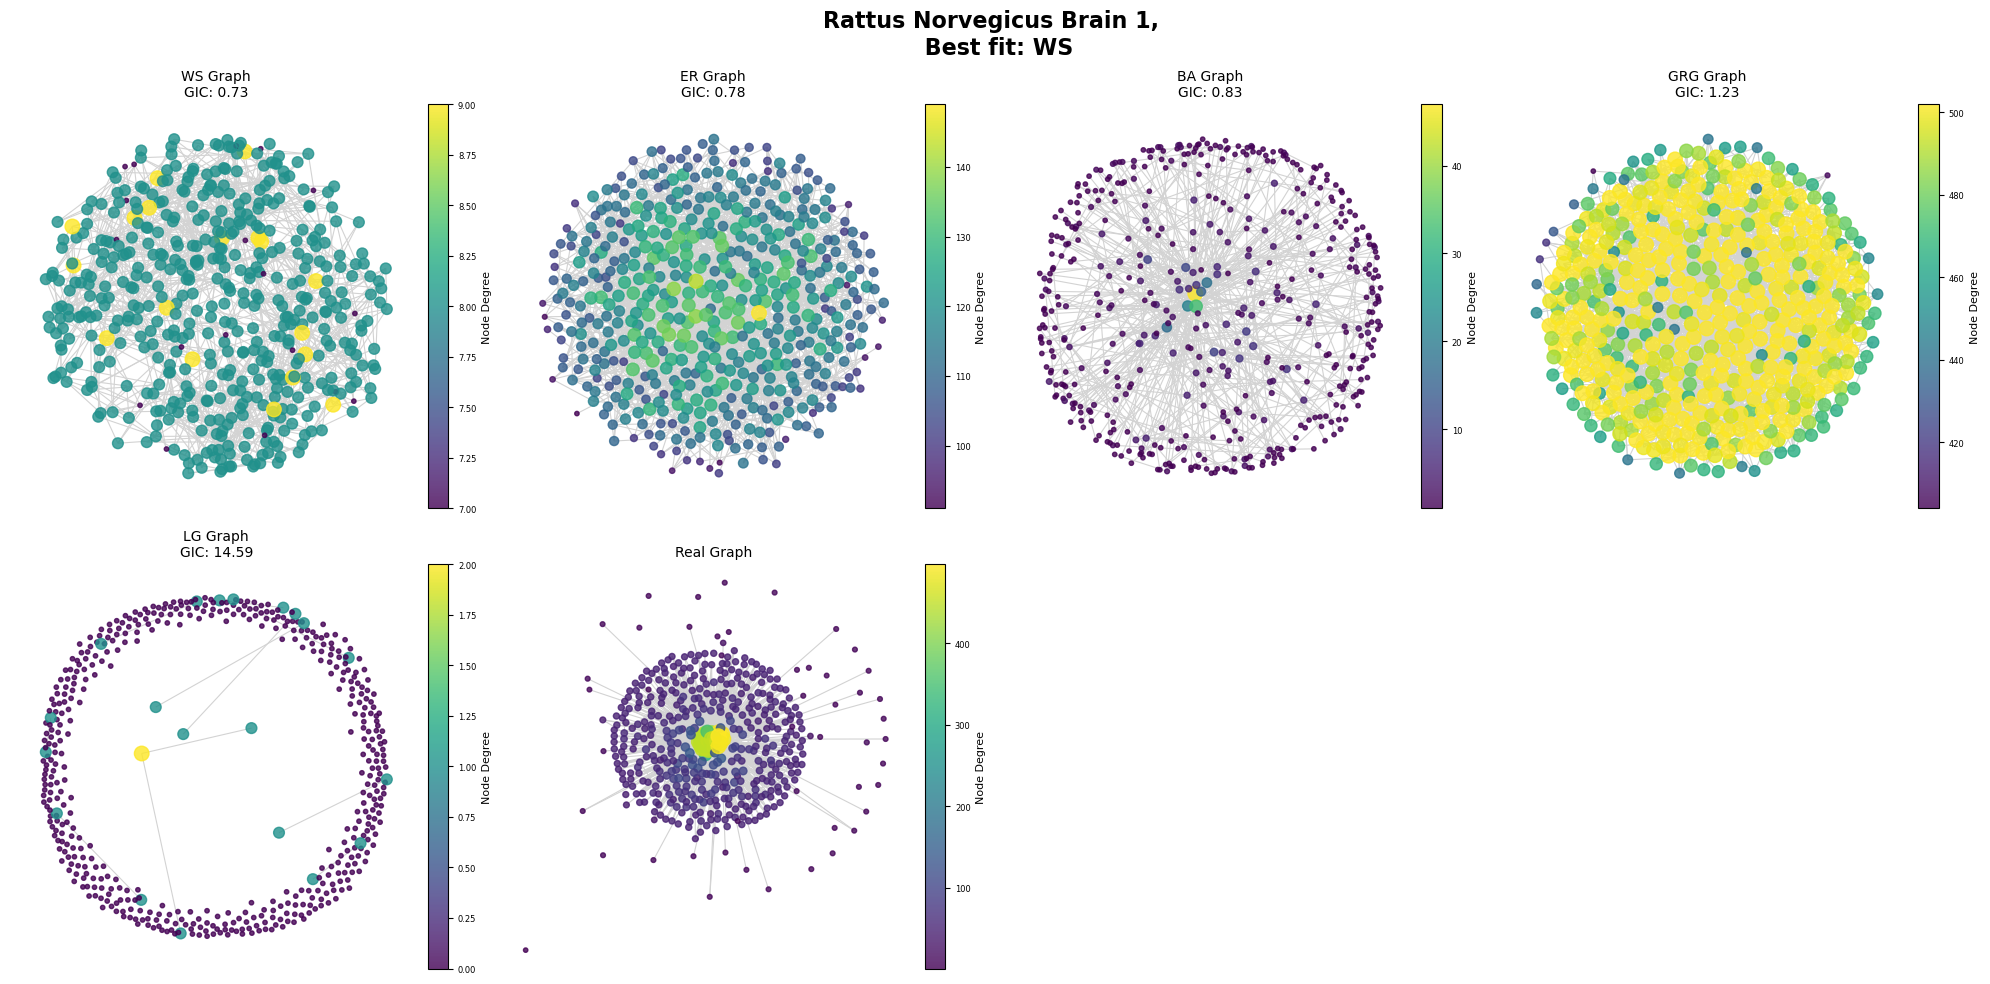

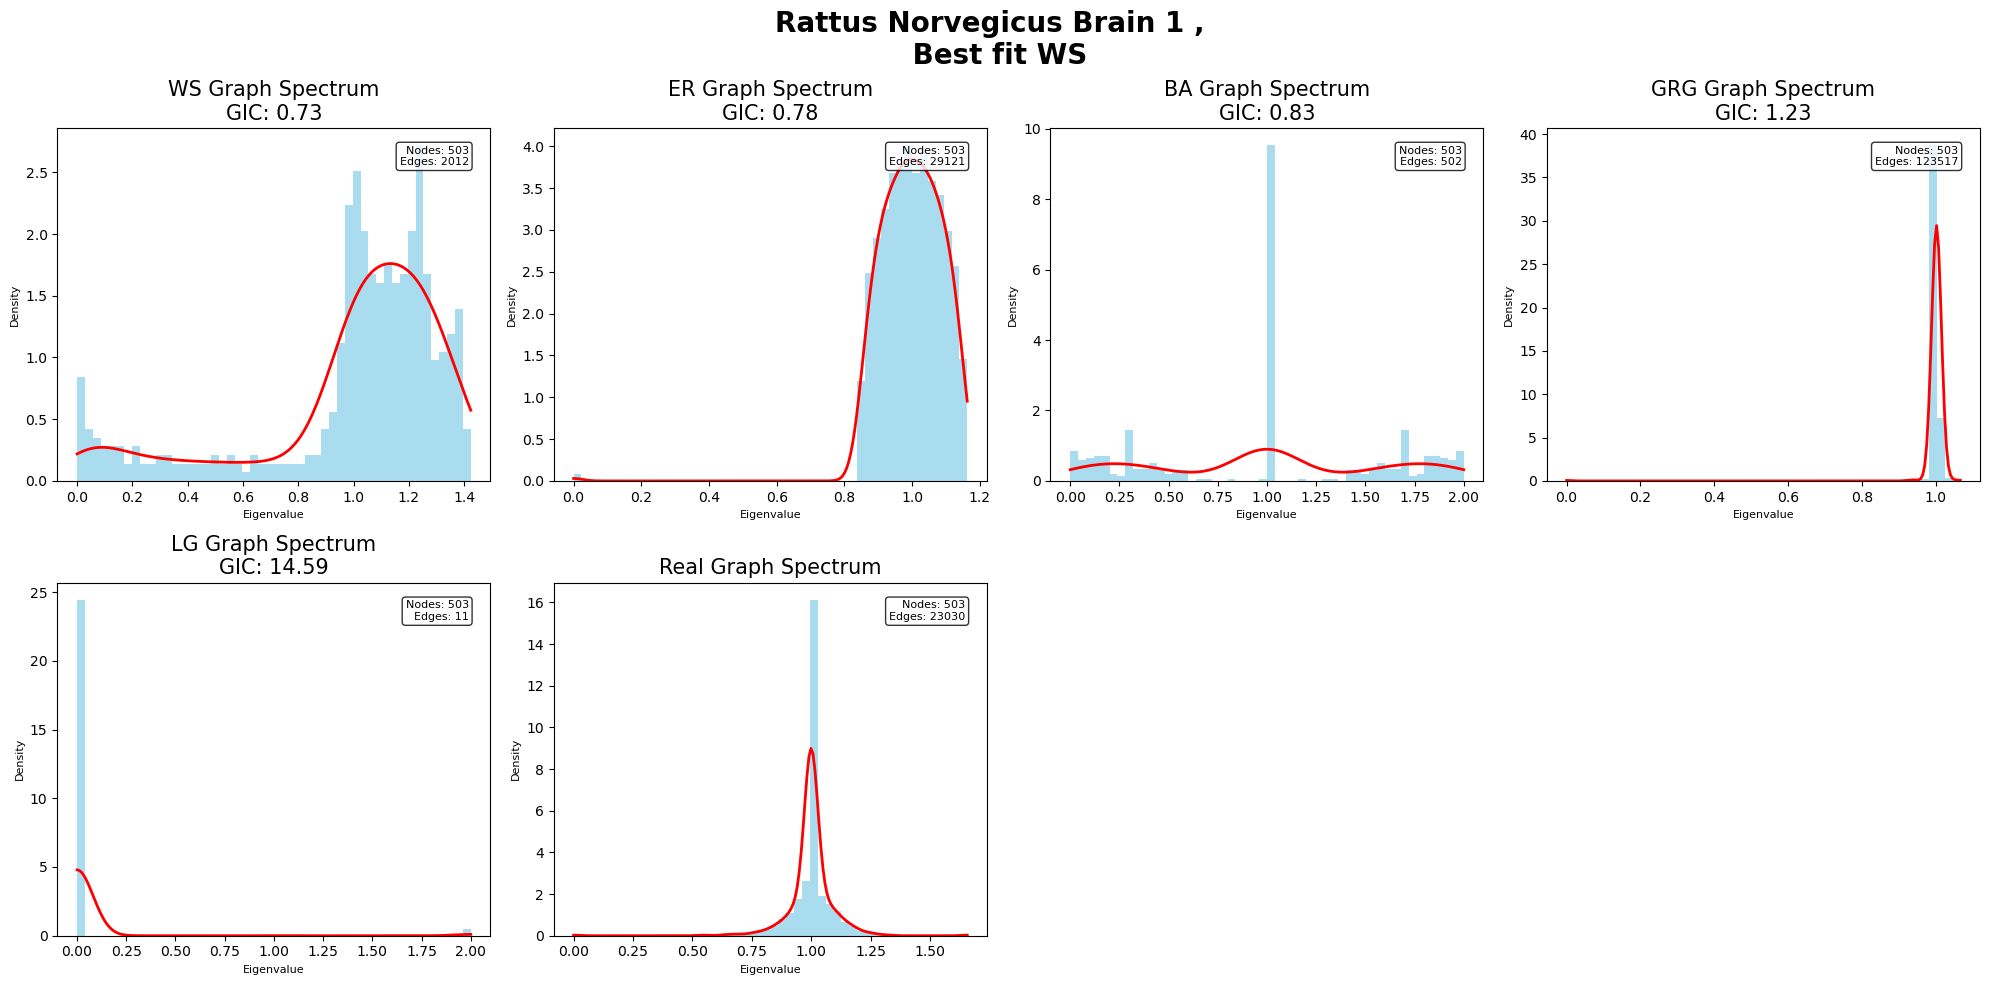

Completed processing for rattus.norvegicus_brain_1.graphml
--------------------
All connectomes processed.


In [51]:
# Plotting the analysis
sim_graphs_dict = {}
for model in model_names:
    if model != 'LG':
        func = selector.model_function(model_name=model)
        graph_sim = func(real_graph.shape[0], float(result_dict[model]['param']))
        sim_graphs_dict[model] = graph_sim
    elif model == 'LG':
        sim_graphs_dict[model] = nx.from_numpy_array(logit_graph)

sim_graphs_dict['Real'] = nx.from_numpy_array(real_graph)

clean_title = os.path.splitext(connectomes[i])[0].replace('_', ' ')
clean_title = clean_title.replace('.', ' ')
clean_title = ' '.join(word.capitalize() for word in clean_title.split())
fig = plot_graphs_in_matrix(sim_graphs_dict,
                            result_dict,
                            global_title=f'{clean_title}, \n Best fit: {min_gic_key}',
                            save_path=f'../images/imgs_connectomes/{connectomes[i]}.png')
plt.show()
plt.close()

# Plot and save spectrum visualizations
fig = plot_spectra_in_matrix(sim_graphs_dict,
                            result_dict,
                            global_title=f'{clean_title} , \n Best fit {min_gic_key}',
                            bins=50,
                            save_path=f'../images/imgs_spectra/spectra_{connectomes[i]}.png')
plt.show()
plt.close()

print(f"Completed processing for {connectomes[i]}")
print("--------------------")

# Add a garbage collection call to free up memory
gc.collect()

print("All connectomes processed.")